In [ ]:
from cerebralcortex.util.helper_methods import get_study_names
sn = get_study_names("/home/jupyter/cc3_conf/")
print(sn)
from pyspark.sql import functions as F
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StructField, StructType, DoubleType,MapType, StringType,ArrayType, FloatType, TimestampType, IntegerType
from pyspark.sql.functions import minute, second, mean, window
from pyspark.sql import functions as F
import numpy as np
import pandas as pd
from cerebralcortex.core.datatypes import DataStream
from cerebralcortex.core.metadata_manager.stream.metadata import Metadata, DataDescriptor, \
ModuleMetadata
from typing import List
import numpy as np
from scipy import signal
import pandas as pd
from cerebralcortex import Kernel
CC = Kernel("/home/jupyter/cc3_conf/", study_name='md2k_aa_rice')

def save_data(ppg_likelihood,stream_name,description='blank'):
    schema = ppg_likelihood._data.schema
    stream_metadata = Metadata()
    stream_metadata.set_name(stream_name).set_description(description)
    for field in schema.fields:
        stream_metadata.add_dataDescriptor(
            DataDescriptor().set_name(str(field.name)).set_type(str(field.dataType))
        )
    stream_metadata.add_module(
        ModuleMetadata().set_name(description) \
        .set_attribute("url", "https://md2k.org").set_author(
            "Md Azim Ullah", "mullah@memphis.edu"))
    stream_metadata.is_valid()
#     ppg_likelihood.printSchema()
    ds = DataStream(data=ppg_likelihood._data,metadata=stream_metadata)
    CC.save_stream(ds,overwrite=False)
users = ['35109a64-411d-4768-9602-c0a3d519a088','9b3e5f2e-99e8-4c4c-8580-6f4e2b107e37','3febca74-f12b-4a1b-a469-22d6cad30e74',
         'f35c1279-806e-4546-839b-037ee01b0116','19223eac-7f2e-429c-8fa7-0977eee8ae7c','5a47080d-a1ec-48f2-a174-a6a017fcb100',
         '099b45df-6432-47d2-8332-a8a870ec79de','903c1dae-a771-405f-a021-6f175724adc4','ad1e878e-7bea-48ca-b890-92770fe02a4c',
         'd768791c-7479-4aaf-a6c8-61e82f1517e8','780e89b3-f6bf-4181-9f2c-7db941735c87','8008f00d-2549-46e4-ab1f-01542c1076e2',
         '34e42cf6-7c34-417c-a003-874e3b6151e7','e099e913-4796-4408-af63-1d35c84f29fd','d3cf5812-85fd-4328-9b2a-1b3b6b2cd0b0',
         'b0954814-ad5a-4a8f-ac5a-8436a70889d0','0c2f18b6-142e-4e9a-ab1b-4d4ea2e91280','bde40f50-8e35-4707-8260-b69f07773c4d',
         '98fca87c-9940-4666-9893-9f8ae2418cb8','780f84d0-eb06-4696-a47d-9320bc17d117','808b555a-6573-457e-b1c6-e008594b0f9a',
         'cd575a70-f1a4-4a2b-ac0d-dd0c330a7912','bb0fe5f5-798b-45ea-be50-8e56e3116369','a19eb22e-8c99-42d5-8a68-caad1dfe9361',
         '9998aedf-5144-4402-9806-fd0965ca85c0','f0286b14-18d2-46bd-845e-f83b43a2ef7b','a94e78e6-acb4-4a71-920a-92b1858d51bd',
         '5f3f7553-6d2f-4c08-adb9-dbc3e88ba0aa','b71b2071-6330-434d-a2ab-8e929e9b96a9','b53e7168-0a87-4646-b389-fb0fe60cc36a',
         '9197be51-f220-4c63-a6a8-3ec1bbd50810','892e71e0-a5a4-4315-89a4-fa5518d78591','96f6e25f-4dd0-4070-a9ac-b04957969382',
         'cfe02b15-0332-4590-9ac6-9ef2eb8b3edd','896d9cb5-2e54-4900-9b8a-58c087549d19','ea2fa266-3e43-4552-8c74-cba474ae0038',
         '263b1782-923d-4bb3-b52d-4c1926e81f1f','9bc2eed3-f75d-479c-9665-75df853bc8ac','9744e4ae-63d8-49df-be6a-37cbb24532a1',
         '2d8b5a8c-e990-4442-abf6-578e96d2f5eb','897fdfcf-9004-4ef6-bf9a-8d3fe339c8ce','9a3bd464-f273-4f97-a48c-1f3c6a705a69']

# '6ef875b3-2f7e-48b8-bf00-de3ee1316830','05846fcf-1dd9-4f98-b17b-1ce6e624c0a7','4bf6078d-afcd-432a-a8a5-8b5e8a4eda9e','2333036a-2f50-49ca-a119-3c5d66399fe4',
# '22c85326-97bf-4e4b-90c4-4255c144ae1b','f8d33ca1-e0fa-4b59-a7c2-b1aee8afcaea','c64ca471-369e-43fa-a07b-8260fd1c745c','fdddb3bd-bb88-458f-bcc8-e50bb3f87742',
# '02543bbf-84c2-4076-8547-c8a5f451ea02','0c726695-f016-4019-9aab-c292298ee10c','87a2bf88-ef4e-4bd5-96b6-eda8faac6a8e','8d96c9a4-a13b-4729-adf3-969e84b9a6d2']
# ]

In [ ]:
from collections import Counter
from scipy.stats import skew,kurtosis,iqr
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import logging
from math import pi, log
import numpy as np
import pylab
from scipy import fft, ifft
from scipy.optimize import curve_fit
from scipy.signal import cspline1d_eval, cspline1d

def _datacheck_peakdetect(x_axis, y_axis):
    if x_axis is None:
        x_axis = range(len(y_axis))
    
    if len(y_axis) != len(x_axis):
        raise ValueError( 
                "Input vectors y_axis and x_axis must have same length")
    
    #needs to be a numpy array
    y_axis = np.array(y_axis)
    x_axis = np.array(x_axis)
    return x_axis, y_axis
    

def _pad(fft_data, pad_len):
    """
    Pads fft data to interpolate in time domain
    
    keyword arguments:
    fft_data -- the fft
    pad_len --  By how many times the time resolution should be increased by
    
    return: padded list
    """
    l = len(fft_data)
    n = _n(l * pad_len)
    fft_data = list(fft_data)
    
    return fft_data[:l // 2] + [0] * (2**n-l) + fft_data[l // 2:]
    
def _n(x):
    """
    Find the smallest value for n, which fulfils 2**n >= x
    
    keyword arguments:
    x -- the value, which 2**n must surpass
    
    return: the integer n
    """
    return int(log(x)/log(2)) + 1
    
    
def _peakdetect_parabola_fitter(raw_peaks, x_axis, y_axis, points):
    func = lambda x, a, tau, c: a * ((x - tau) ** 2) + c
    fitted_peaks = []
    distance = abs(x_axis[raw_peaks[1][0]] - x_axis[raw_peaks[0][0]]) / 4
    for peak in raw_peaks:
        index = peak[0]
        x_data = x_axis[index - points // 2: index + points // 2 + 1]
        y_data = y_axis[index - points // 2: index + points // 2 + 1]
        # get a first approximation of tau (peak position in time)
        tau = x_axis[index]
        # get a first approximation of peak amplitude
        c = peak[1]
        a = np.sign(c) * (-1) * (np.sqrt(abs(c))/distance)**2
        """Derived from ABC formula to result in a solution where A=(rot(c)/t)**2"""
        
        # build list of approximations
        
        p0 = (a, tau, c)
        popt, pcov = curve_fit(func, x_data, y_data, p0)
        # retrieve tau and c i.e x and y value of peak
        x, y = popt[1:3]
        
        # create a high resolution data set for the fitted waveform
        x2 = np.linspace(x_data[0], x_data[-1], points * 10)
        y2 = func(x2, *popt)
        
        fitted_peaks.append([x, y, [x2, y2]])
        
    return fitted_peaks
    
    
def peakdetect_parabole(*args, **kwargs):
    """
    Misspelling of peakdetect_parabola
    function is deprecated please use peakdetect_parabola
    """
    logging.warn("peakdetect_parabole is deprecated due to misspelling use: peakdetect_parabola")
    
    return peakdetect_parabola(*args, **kwargs)
    
    
def peakdetect(y_axis, x_axis = None, lookahead = 200, delta=0):
    max_peaks = []
    min_peaks = []
    dump = []   #Used to pop the first hit which almost always is false
       
    # check input data
    x_axis, y_axis = _datacheck_peakdetect(x_axis, y_axis)
    # store data length for later use
    length = len(y_axis)
    
    
    #perform some checks
    if lookahead < 1:
        raise ValueError("Lookahead must be '1' or above in value")
    if not (np.isscalar(delta) and delta >= 0):
        raise ValueError("delta must be a positive number")
    
    #maxima and minima candidates are temporarily stored in
    #mx and mn respectively
    mn, mx = np.Inf, -np.Inf
    
    #Only detect peak if there is 'lookahead' amount of points after it
    for index, (x, y) in enumerate(zip(x_axis[:-lookahead], 
                                        y_axis[:-lookahead])):
        if y > mx:
            mx = y
            mxpos = x
        if y < mn:
            mn = y
            mnpos = x
        
        ####look for max####
        if y < mx-delta and mx != np.Inf:
            #Maxima peak candidate found
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].max() < mx:
                max_peaks.append([mxpos, mx])
                dump.append(True)
                #set algorithm to only find minima now
                mx = np.Inf
                mn = np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
                continue
            #else:  #slows shit down this does
            #    mx = ahead
            #    mxpos = x_axis[np.where(y_axis[index:index+lookahead]==mx)]
        
        ####look for min####
        if y > mn+delta and mn != -np.Inf:
            #Minima peak candidate found 
            #look ahead in signal to ensure that this is a peak and not jitter
            if y_axis[index:index+lookahead].min() > mn:
                min_peaks.append([mnpos, mn])
                dump.append(False)
                #set algorithm to only find maxima now
                mn = -np.Inf
                mx = -np.Inf
                if index+lookahead >= length:
                    #end is within lookahead no more peaks can be found
                    break
            #else:  #slows shit down this does
            #    mn = ahead
            #    mnpos = x_axis[np.where(y_axis[index:index+lookahead]==mn)]
    
    
    #Remove the false hit on the first value of the y_axis
    try:
        if dump[0]:
            max_peaks.pop(0)
        else:
            min_peaks.pop(0)
        del dump
    except IndexError:
        pass
        
    return [max_peaks, min_peaks]
def get_predict_prob(window):
    window[:,:] = signal.detrend(RobustScaler().fit_transform(window),axis=0)
    f,pxx = signal.welch(window,fs=25,nperseg=len(window),nfft=10000,axis=0)
    pxx = np.abs(pxx)
    pxx = MinMaxScaler().fit_transform(pxx)
    skews = skew(window,axis=0).reshape(3,1)
    kurs = kurtosis(window,axis=0).reshape(3,1)
    iqrs = np.std(window,axis=0).reshape(3,1)
    rps = np.divide(np.trapz(pxx[np.where((f>=.8)&(f<=2.5))[0]],axis=0),np.trapz(pxx,axis=0)).reshape(3,1)
    features = np.concatenate([skews,kurs,rps,iqrs],axis=1)
    return features

def get_rr_value(values):
    try:
        f, pxx = signal.welch(values,fs=25,nperseg=values.shape[0],nfft=10000,axis=0)
        f = f.reshape(-1)
        pxx = pxx.reshape(-1,1)
        peakind =  peakdetect(pxx[:,0],lookahead=2)
        x = []
        y = []
        for a in peakind[0]:
            x.append(a[0])
            y.append(a[1])
        x = np.array(x)
        x = x[f[x]>.8]
        x = x[f[x]<2.5]
        f = f[x]
        pxx = pxx[x,0]
        return 60000/(60*f[np.argmax(pxx)])
    except Exception as e:
        return 0

def get_likelihood_custom_seconds(bandpass_filtered_stream,duration,user):
    schema2 = StructType([
        StructField("version", IntegerType()),
        StructField("user", StringType()),
        StructField("localtime", TimestampType()),
        StructField("timestamp", TimestampType()),
        StructField("features", ArrayType(DoubleType())),
        StructField("rr", ArrayType(DoubleType())),
        StructField("quality", DoubleType()),
        StructField("activity", DoubleType()),
        StructField("start", TimestampType()),
        StructField("end", TimestampType())
        
    ])
    @pandas_udf(schema2, PandasUDFType.GROUPED_MAP)
    def ppg_features_compute(key,data):
        if data.shape[0]>45:
            data = data.sort_values('timestamp').reset_index(drop=True)
            rows = []
            rows.append(data['user'].loc[0])
            rows.append(data['version'].loc[0])
            rows.append(data['quality'].loc[0])
            rows.append(data['timestamp'].loc[0])
            rows.append(data['localtime'].loc[0])
            rows.append(np.array([get_rr_value(data['red'].values),
                           get_rr_value(data['infrared'].values),
                           get_rr_value(data['green'].values)]))

            data_ppg = data[['red','infrared','green']]
            values = data_ppg.values
            feature = get_predict_prob(values)
            rows.append(feature.reshape(-1))

            data_acl = data[['aclx','acly','aclz']]
            values_acl = data_acl.values
            acl_std = np.std(values_acl,axis=0)
            acl_std = np.sqrt(np.sum(np.square(acl_std)))
            rows.append(acl_std)
            rows.append(key[2]['start'])
            rows.append(key[2]['end'])
            return pd.DataFrame([rows],columns=['user','version','quality',
                                            'timestamp','localtime',
                                            'rr','features','activity','start','end'])

        else:
            return pd.DataFrame([],columns=['user','version','quality',
                                            'timestamp','localtime',
                                            'rr','features','activity','start','end'])

    ppg_bandpass_filtered = CC.get_stream(bandpass_filtered_stream).drop(*['gyrox','gyroy','gyroz'])
    ppg_features = ppg_bandpass_filtered.compute(ppg_features_compute,windowDuration=duration,slideDuration=1,startTime='0 seconds')
    schema3 = StructType([
        StructField("version", IntegerType()),
        StructField("user", StringType()),
        StructField("localtime", TimestampType()),
        StructField("timestamp", TimestampType()),
        StructField("likelihood_max", DoubleType()),
        StructField("rr", DoubleType()),
        StructField("likelihood_max_array", ArrayType(DoubleType())),
        StructField("rr_array", ArrayType(DoubleType())),
        StructField("activity", DoubleType()),
        StructField("start", TimestampType()),
        StructField("end", TimestampType())
    ])
    import pickle
    import warnings
    clf = pickle.load(open('/home/jupyter/mullah/cc3/classifier.p','rb'))

    def convert_to_array(vals):
        return vals.reshape(3,4)

    @pandas_udf(schema3, PandasUDFType.GROUPED_MAP)
    def ppg_likelihood_compute(key,data):
        if data.shape[0]>0:
            data['features'] = data['features'].apply(convert_to_array)
            acl_features = np.concatenate(list(data['features'])).reshape(-1,3,4)
            likelihood = []
            for k in range(acl_features.shape[1]):
                tmp = np.nan_to_num(acl_features[:,k,:]).reshape(-1,4)
                likelihood.append(clf.predict_proba(tmp)[:,1].reshape(-1,1))
            likelihood = np.concatenate(likelihood,axis=1)
            rrs = data['rr'].values
            likelihood_max = []
            rr = []
            rr_array = []
            likelihood_max_array = []
            for i in range(likelihood.shape[0]):
                a = likelihood[i,:]
                likelihood_max_array.append(list(a))
                rr_array.append(list(rrs[i]))
                likelihood_max.append(np.max(a))
                rr.append(rrs[i][np.argmax(a)])
            data['likelihood_max'] = likelihood_max
            data['rr'] = rr
            data['likelihood_max_array'] = likelihood_max_array
            data['rr_array'] = rr_array
            data.drop(columns=['features','quality'],inplace=True)
            return data
        else:
            return pd.DataFrame([],columns=['user','version','timestamp','localtime','likelihood_max',
                                            'rr','activity','likelihood_max_array','rr_array','start','end'])

    ppg_likelihood = ppg_features.compute(ppg_likelihood_compute,windowDuration=60*60*12,startTime='0 seconds')
    data_ppg = ppg_likelihood.select(*['version','user','localtime','timestamp','likelihood_max','rr',
                        'likelihood_max_array','rr_array','activity',F.struct('start', 'end').alias('window')])
    rr = CC.get_stream('org.md2k.autosense.ecg.rr.final.pan.tomkins')
    ecg = rr.compute_average(windowDuration=duration,startTime='0 seconds',slideDuration='1 seconds').withColumnRenamed('rr','ecg_rr').drop('timestamp',
                                                                                                                                        'localtime',
                                                                                                                                        'version')
    data_final = data_ppg.join(ecg,on=['window','user'],how='left')
    return data_final.withColumn('version',F.lit(0))


In [ ]:
for duration in np.arange(2,16,1):
    bandpass_filtered_stream = "org.md2k.motionsensehrv.left.wrist.bandpass.filtered"
#     for user in users:
    data_all = get_likelihood_custom_seconds(bandpass_filtered_stream,duration,'-')
    save_data(data_all,'ecg.ppg.rr.left-'+str(duration)+'-seconds1')
    print(duration,'done')
    print('-'*30)

In [ ]:
data_all._data.schema

In [ ]:
all_dfs = []
for duration in np.arange(2,16,1):
    df = CC.get_stream('ecg.ppg.rr.left-'+str(duration)+'-seconds').dropna().toPandas()
    final_df = df[(df.rr>300) & (df.rr<1500) & (df.ecg_rr>300) & (df.ecg_rr<1500)]
    final_df['likelihood'] = final_df['likelihood_max'].apply(lambda a:np.round(a*100)/100) 
    final_df['difference'] = final_df.apply(lambda a:np.abs(a['rr']-a['ecg_rr']),axis=1) 
    all_dfs.append(final_df)

In [ ]:
import pickle
pickle.dump(all_dfs,open('../data/rice/all_duration_dfs.p','wb'))

In [ ]:
final_df = df[(df.rr>300) & (df.rr<1500) & (df.ecg_rr>300) & (df.ecg_rr<1500)]

In [ ]:
final_df['likelihood'] = final_df['likelihood_max'].apply(lambda a:np.round(a*100)/100) 

In [ ]:
final_df['difference'] = final_df.apply(lambda a:np.abs(a['rr']-a['ecg_rr']),axis=1) 

In [ ]:
final_df.groupby('likelihood').mean()['difference'].plot()

In [30]:
import pickle
all_dfs = pickle.load(open('../data/rice/all_duration_dfs.p','rb'))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(20,10))
durations = np.arange(2,16,1)
likelihoods = []
for i,df in enumerate(all_dfs):
#     if i%2==1:
#         continue
    df = deepcopy(df)
    duration = durations[i]
    df[str(duration)+'-seconds'] = df['difference']
    df.set_index('timestamp',inplace=True)
    df = pd.concat([df1 for i,df1 in df.groupby(pd.Grouper(freq='60S')) if df1.shape[0]>0 and np.percentile(df1['likelihood_max'],80)>.5])    
    df['likelihood'] = df['likelihood_max'].apply(lambda a:np.round((a*99.99)//5))
    if i==6:
        likelihoods.extend(list(df['likelihood']*20))
    results = df.groupby('likelihood',as_index=False).mean()[['likelihood',str(duration)+'-seconds']]
    plt.plot(results['likelihood']*20,results[str(duration)+'-seconds'],linestyle='dashdot',marker='o',label=str(duration)+'-seconds',linewidth=3)
ax1 = plt.gca()
ax = ax1.twinx()
ax.hist(likelihoods,200,alpha=.25,density=True,edgecolor='red',linewidth=2)
ax.set_ylabel('Density of Yield in Different Ranges of signal Quality',color='red')
ax.tick_params(axis='y', labelcolor='red')
ax1.legend(ncol=5,loc='upper right')
labels = [str("{:.2f}".format(i/20))+'-'+str("{:.2f}".format(i/20+.05))  for i in np.arange(0,20,1)]
# labels[-1] = '==1.00'
ax1.set_xticklabels(labels)
ax1.set_xticks(np.arange(0,20,1)*20)
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_ylabel('Mean Absolute Difference in milliseconds',color='green')
for tick in ax1.get_xticklabels():
    tick.set_rotation(60)
ax1.set_xlabel('Different Ranges of Signal Quality Likelihood')
plt.show()

In [34]:
df = all_dfs[1]
import pandas  as pd

In [ ]:
df.set_index('timestamp',inplace=True)

In [10]:
import numpy as np
final_df = pd.concat([df1 for i,df1 in df.groupby(pd.Grouper(freq='60S')) if df1.shape[0]>0 and np.percentile(df1['likelihood_max'],80)>.5])    

In [8]:
df.shape

(291941, 12)

In [11]:
final_df.shape

(155034, 12)

(array([27830., 14158., 11584., 11396., 10915., 11162., 11766., 14310.,
        14627., 27286.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

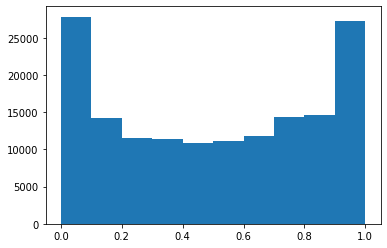

In [13]:
import matplotlib.pyplot as plt
plt.hist(final_df['likelihood_max'])